<a href="https://colab.research.google.com/github/LikaOkudzhava/BrainyScan/blob/InceptionV3/Alzheimer_model_inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install /content/drive/MyDrive/AI/brainy-1.1.tar.gz

Processing ./drive/MyDrive/AI/brainy-1.1.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for brainy: filename=brainy-1.1-py3-none-any.whl size=6438 sha256=755ae00874f7ae61df531e97b2e89c41311062902340eb812ec63c4c0bd322cd
  Stored in directory: /root/.cache/pip/wheels/3a/ba/37/b1c9047aa750b321450fdfb32c5c538366dba41aeab755aba3
Successfully built brainy


In [ ]:
import os
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [ ]:
import os

import zipfile

from google.colab import drive

gdrive = '/content/drive'

gdisk = os.path.join(gdrive, 'MyDrive')

filename = 'smallpreprocessed'

archive_path = os.path.join(gdisk, filename)

with zipfile.ZipFile('/content/drive/MyDrive/AI/smallpreprocessed.zip', 'r') as zip_ref:

 zip_ref.extractall(f'{filename}')

In [ ]:
dataset_dir = '/content/smallpreprocessed/data/SmallPreprocessed'
image_height = 299
image_width = 299
batch_size = 16


train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'train'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'test'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, 'val'),
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = True
)

for ds in [train_ds, test_ds, val_ds]:
    ds.cache()
    ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 12000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.
Found 2000 files belonging to 4 classes.


In [ ]:
from tensorflow import keras

# Load InceptionV3 with all layers frozen
model = keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299, 3)
)

# Freeze all layers
for layer in model.layers:
    layer.trainable = False

In [ ]:
from tensorflow import keras
import tensorflow as tf

# Image dimensions
image_height = 299
image_width = 299
input_shape = (image_height, image_width, 3)

# Input layer
inputs = keras.Input(shape=input_shape)

# Skip augmentation — direct input
x = inputs

# Load InceptionV3 base model with pretrained weights
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'  # Outputs a global average pooled vector
)
base_model.trainable = False  # Freeze pretrained weights

# Pass input through base model
x = base_model(x)

# Custom classification head
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)  # 4 classes

# Combine into a full model
model = keras.Model(inputs=inputs, outputs=outputs)

# Show model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_379         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_380         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_381         │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,121,892 (107.28 MB)

 Trainable params: 6,308,868 (24.07 MB)

 Non-trainable params: 21,813,024 (83.21 MB)

In [ ]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model Checkpoint - save only the best model
checkpoint_cb = ModelCheckpoint(
    "model_InceptionV3.keras",  # Updated filename
    save_best_only=True
)

# Early Stopping - stop if no improvement for 10 epochs
early_stopping_cb = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
EPOCHS = 25

In [ ]:
# Now train with class weights
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb],
    # class_weight=class_weights
)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 271s 247ms/step - accuracy: 0.5479 - loss: 1.2840 - val_accuracy: 0.6995 - val_loss: 0.9125
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.7972 - loss: 0.5175 - val_accuracy: 0.8715 - val_loss: 0.3494
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 188s 250ms/step - accuracy: 0.9094 - loss: 0.2491 - val_accuracy: 0.9275 - val_loss: 0.1934
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 199s 246ms/step - accuracy: 0.9388 - loss: 0.1698 - val_accuracy: 0.9075 - val_loss: 0.3076
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 185s 246ms/step - accuracy: 0.9548 - loss: 0.1282 - val_accuracy: 0.8645 - val_loss: 0.3903
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 185s 246ms/step - accuracy: 0.9656 - loss: 0.0974 - val_accuracy: 0.9490 - val_loss: 0.1329
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 183s 243ms/step - accuracy: 0.9746 - loss: 0.0700 - val_accuracy: 0.9405 - val_loss: 0.1527
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 182s 243ms/step - accuracy: 0.9745 -

In [ ]:
for layer in model.layers[-10:]:
    layer.trainable = True

In [ ]:
# Now train with class weights
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb],
    # class_weight=class_weights
)

In [ ]:
model.save('/content/model_InceptionV3.keras')
model.export('/content/models/inceptionV3_model')

Saved artifact at '/content/models/inceptionV3_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_942')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132108190904208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190902672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190904592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190904784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190906128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190904976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190906512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190906704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190907664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132108190906896: TensorSpec(shape=(), dtype=tf.resource, name=N

In [ ]:
hist_=pd.DataFrame(history.history)

In [ ]:
score, acc= model.evaluate(test_ds)
print('Val Loss =', score)
print('Val Accuracy =', acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9775 - loss: 0.0743
Val Loss = 0.09799399226903915
Val Accuracy = 0.9695000052452087


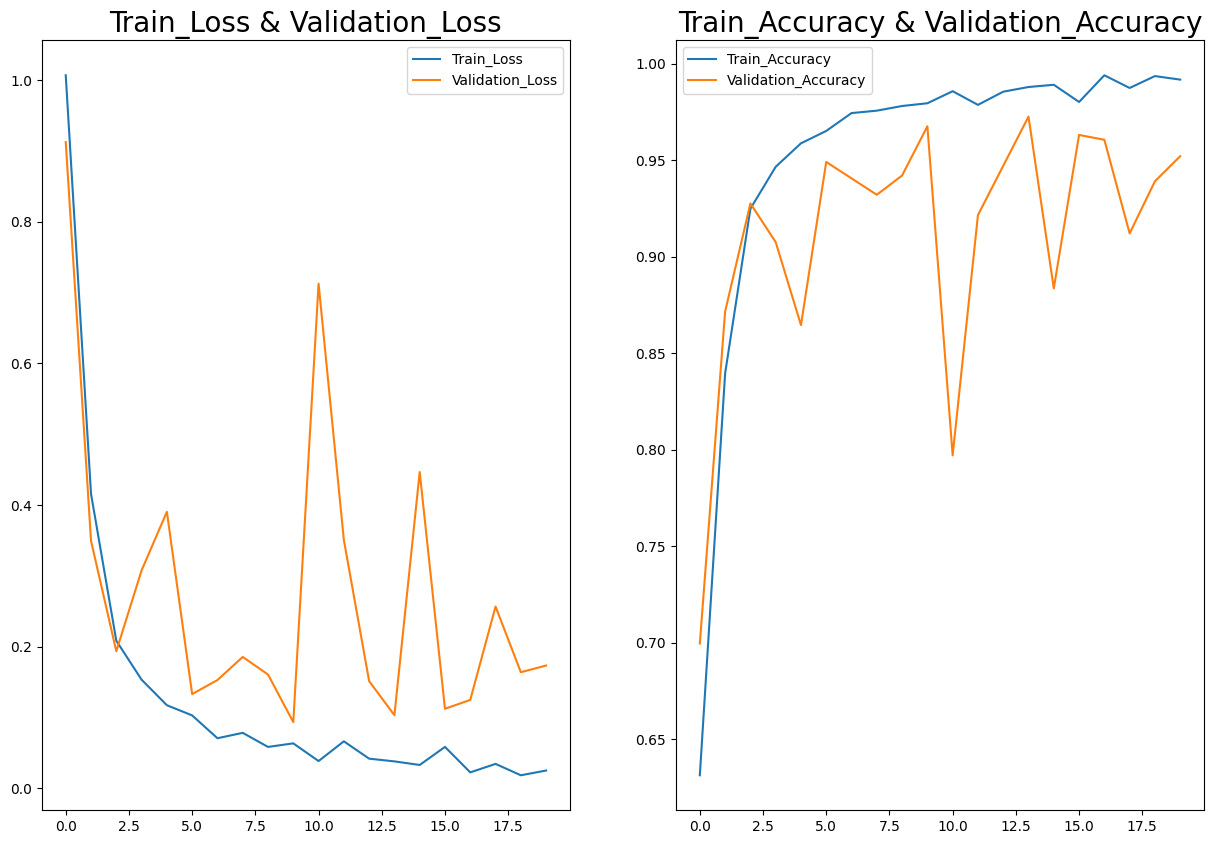

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Convert test labels (one-hot) to class indices
y_test_labels = []
for batch in test_ds:
    images, labels = batch
    y_test_labels.append(labels.numpy())

y_test = np.concatenate(y_test_labels, axis=0)
y_test = np.argmax(y_test, axis=1)  # Convert one-hot to class index

# Predict using model
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)  # Class index

# Create a DataFrame with Actual vs Prediction
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})


125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step


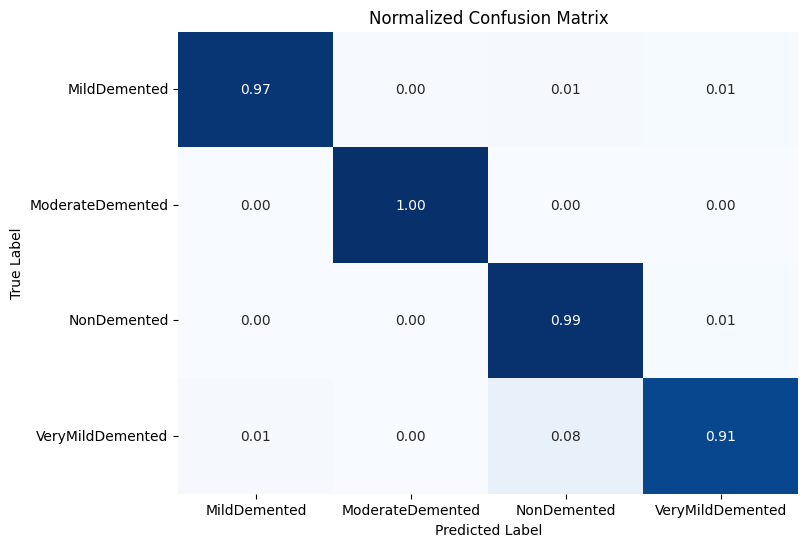

array([[487,   2,   7,   4],
       [  0, 500,   0,   0],
       [  0,   0, 496,   4],
       [  6,   0,  38, 456]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure your predicted and true labels are available
# y_test and y_pred should be 1D arrays of class indices

# Define class labels (update to match your actual class names)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Compute the confusion matrix
CM = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(CM_percent,
            fmt='.2f',
            annot=True,
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

# Optionally print the raw CM
CM


In [ ]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_names)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                    precision    recall  f1-score   support

    MildDemented       0.99      0.97      0.98       500
ModerateDemented       1.00      1.00      1.00       500
     NonDemented       0.92      0.99      0.95       500
VeryMildDemented       0.98      0.91      0.95       500

        accuracy                           0.97      2000
       macro avg       0.97      0.97      0.97      2000
    weighted avg       0.97      0.97      0.97      2000

